In [ ]:
# (i) Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB


In [ ]:
# (ii) Import dataset
df = pd.read_csv('spambase_csv.xls')
target = 'class'

In [ ]:
# (iii) EDA and Preprocessing

def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [ ]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Removal (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #df = df[~((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR))]

In [ ]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

In [ ]:
# --- Encoding categorical features ---
is_classification = True

if is_classification:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # encode target
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # Similar to one-hot encoding as BernoulliNB requires binary values
else:
    # Regression: target guided ordinal encoding
    for col in categorical_cols:
        ordered_labels = df.groupby(col)[target].mean().sort_values().index
        mapping = {k: i for i, k in enumerate(ordered_labels)}
        df[col] = df[col].map(mapping)

In [ ]:
# --- Scaling ---
for col in numerical_cols:
    binarizer = Binarizer(threshold=0.0)
    df[[col]] = binarizer.fit_transform(df[[col]])

print(df)

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0                0.0                1.0            1.0           0.0   
1                1.0                1.0            1.0           0.0   
2                1.0                0.0            1.0           0.0   
3                0.0                0.0            0.0           0.0   
4                0.0                0.0            0.0           0.0   
...              ...                ...            ...           ...   
4596             1.0                0.0            1.0           0.0   
4597             0.0                0.0            0.0           0.0   
4598             1.0                0.0            1.0           0.0   
4599             1.0                0.0            0.0           0.0   
4600             0.0                0.0            1.0           0.0   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0               1.0             0.0               0.0     

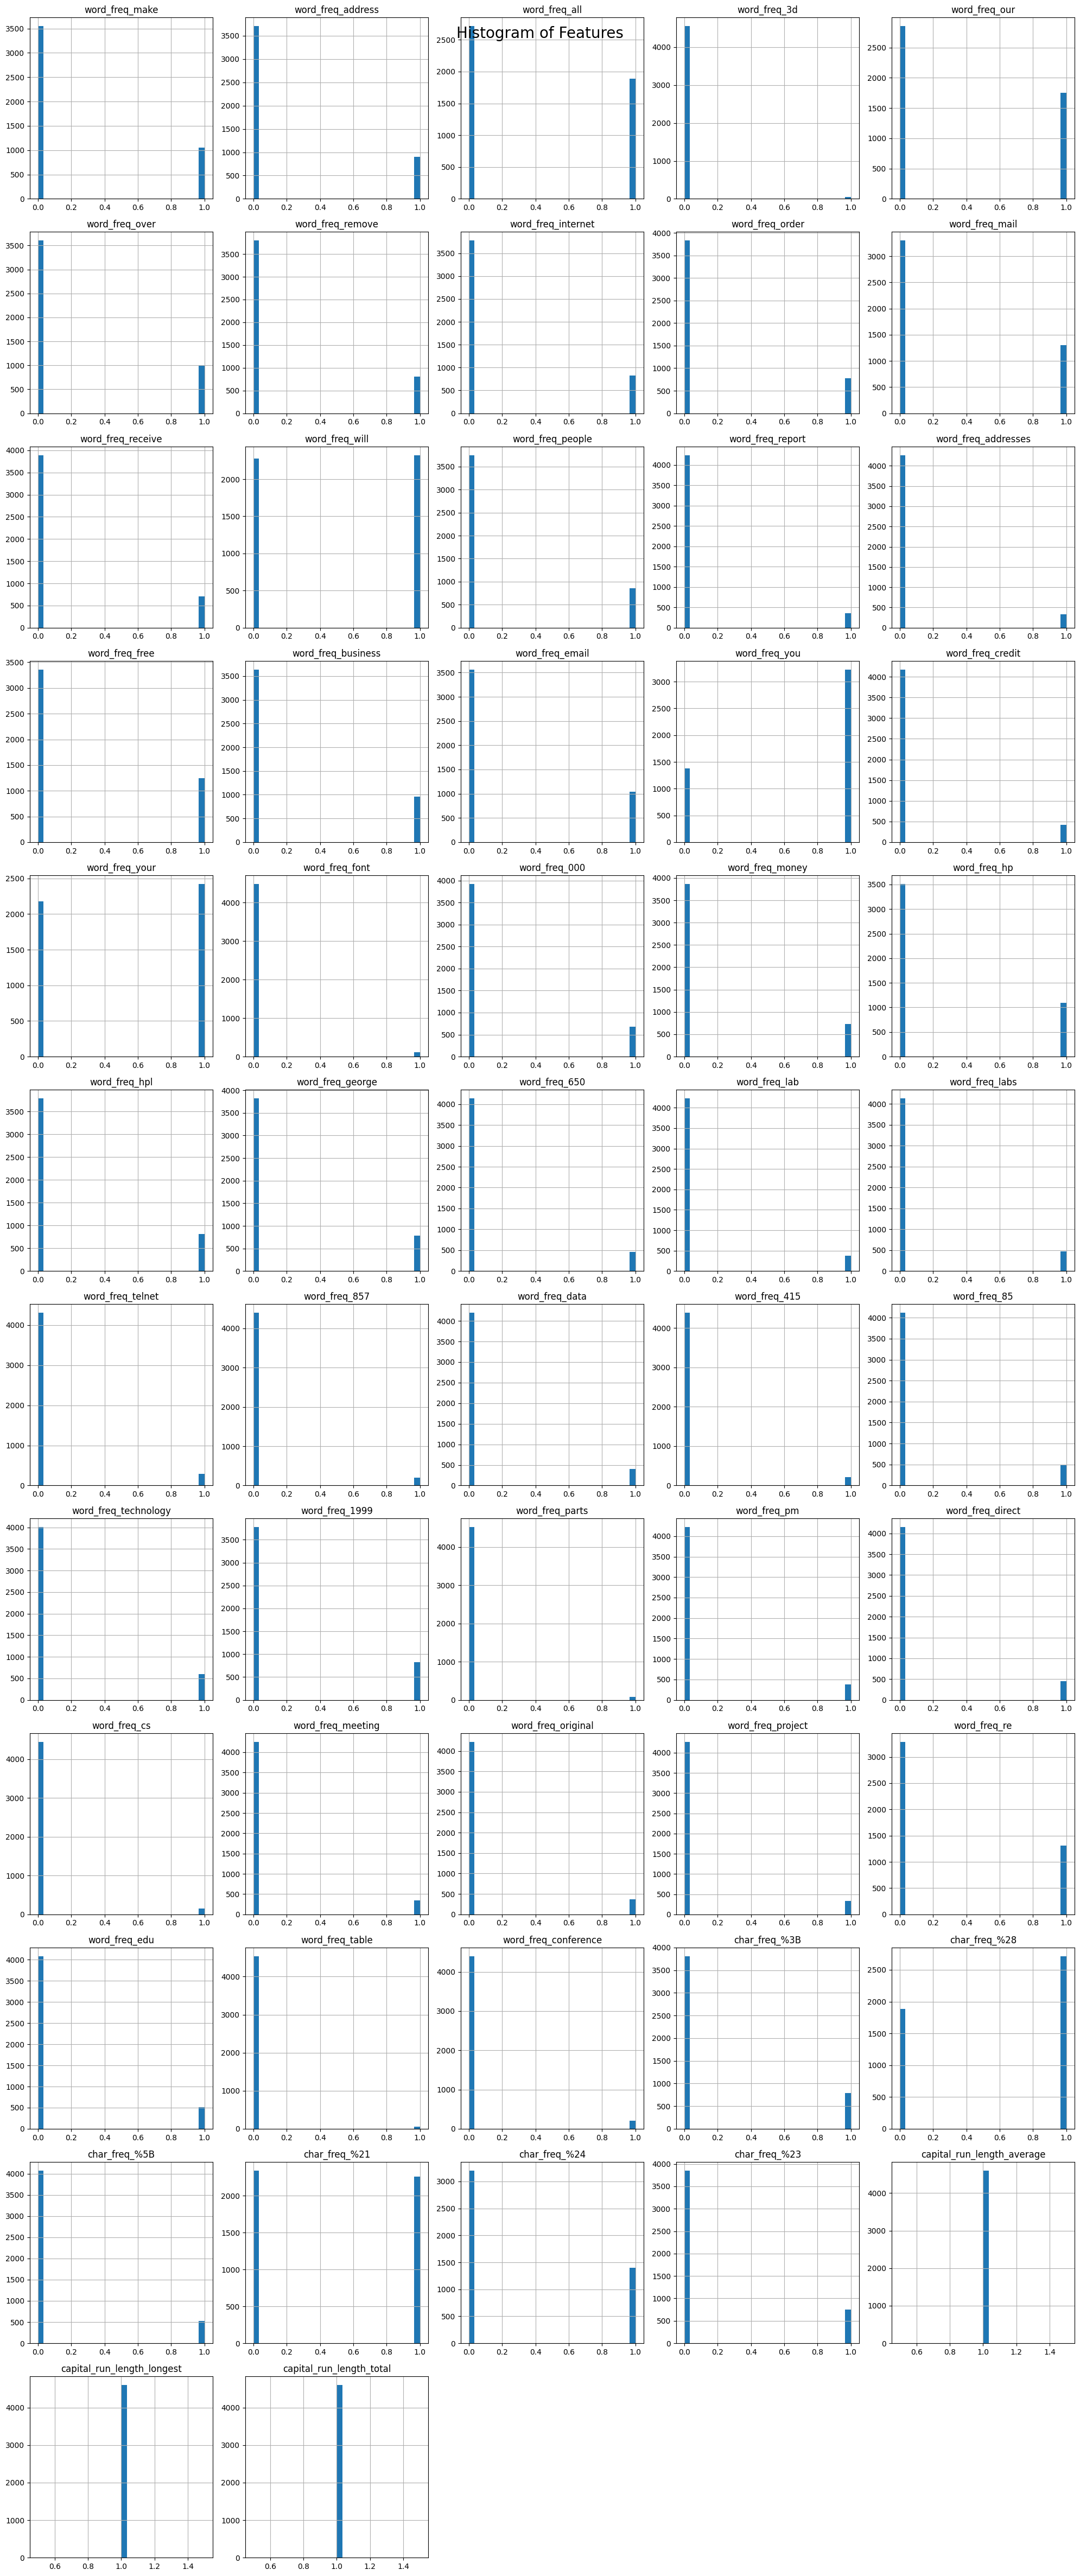

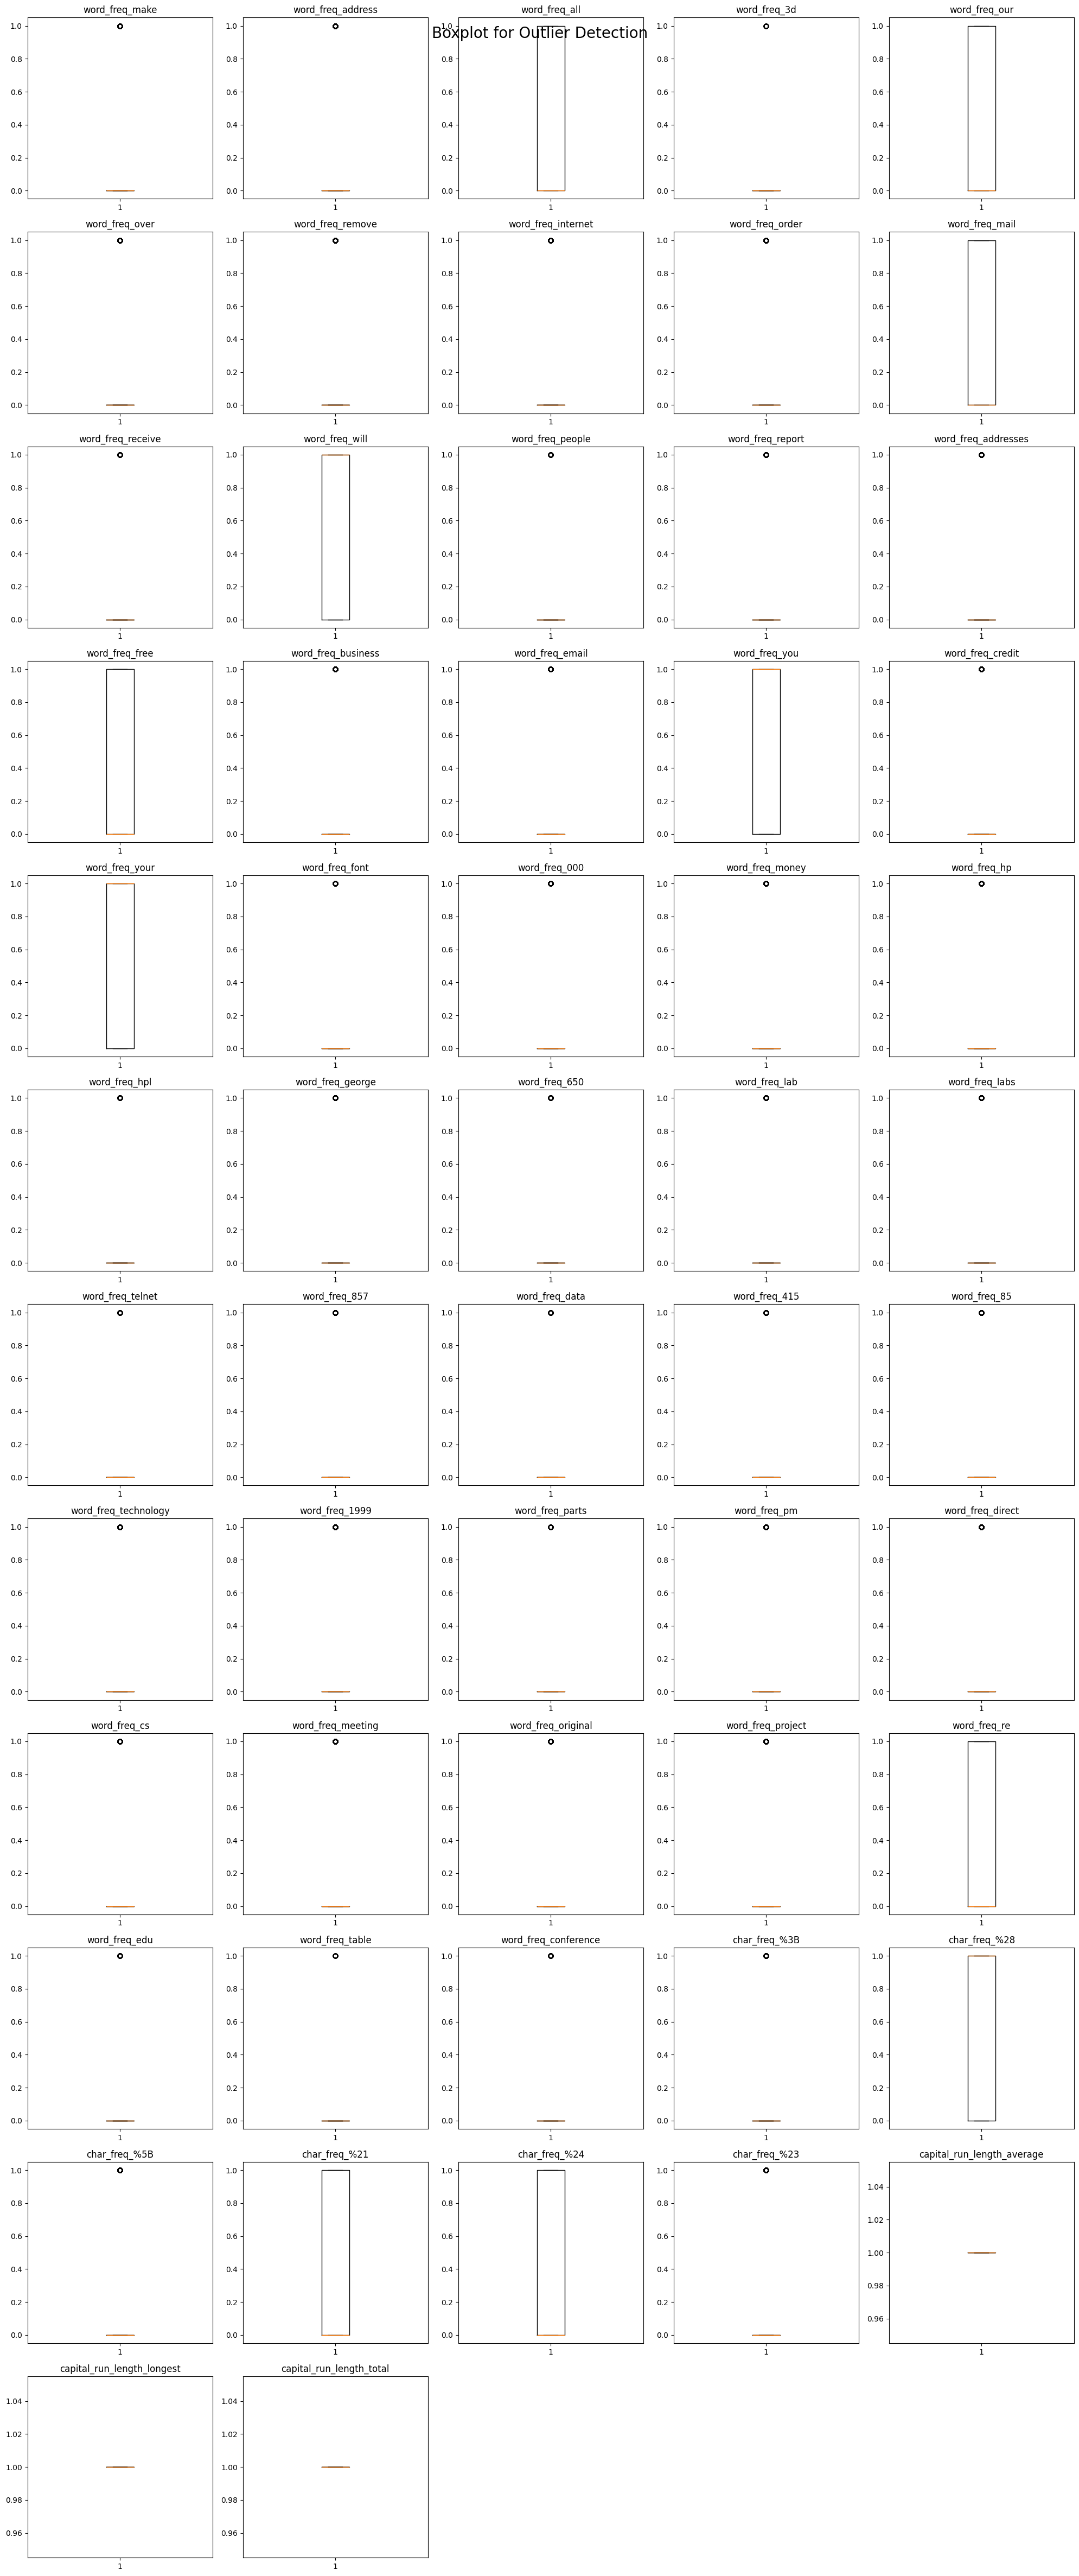

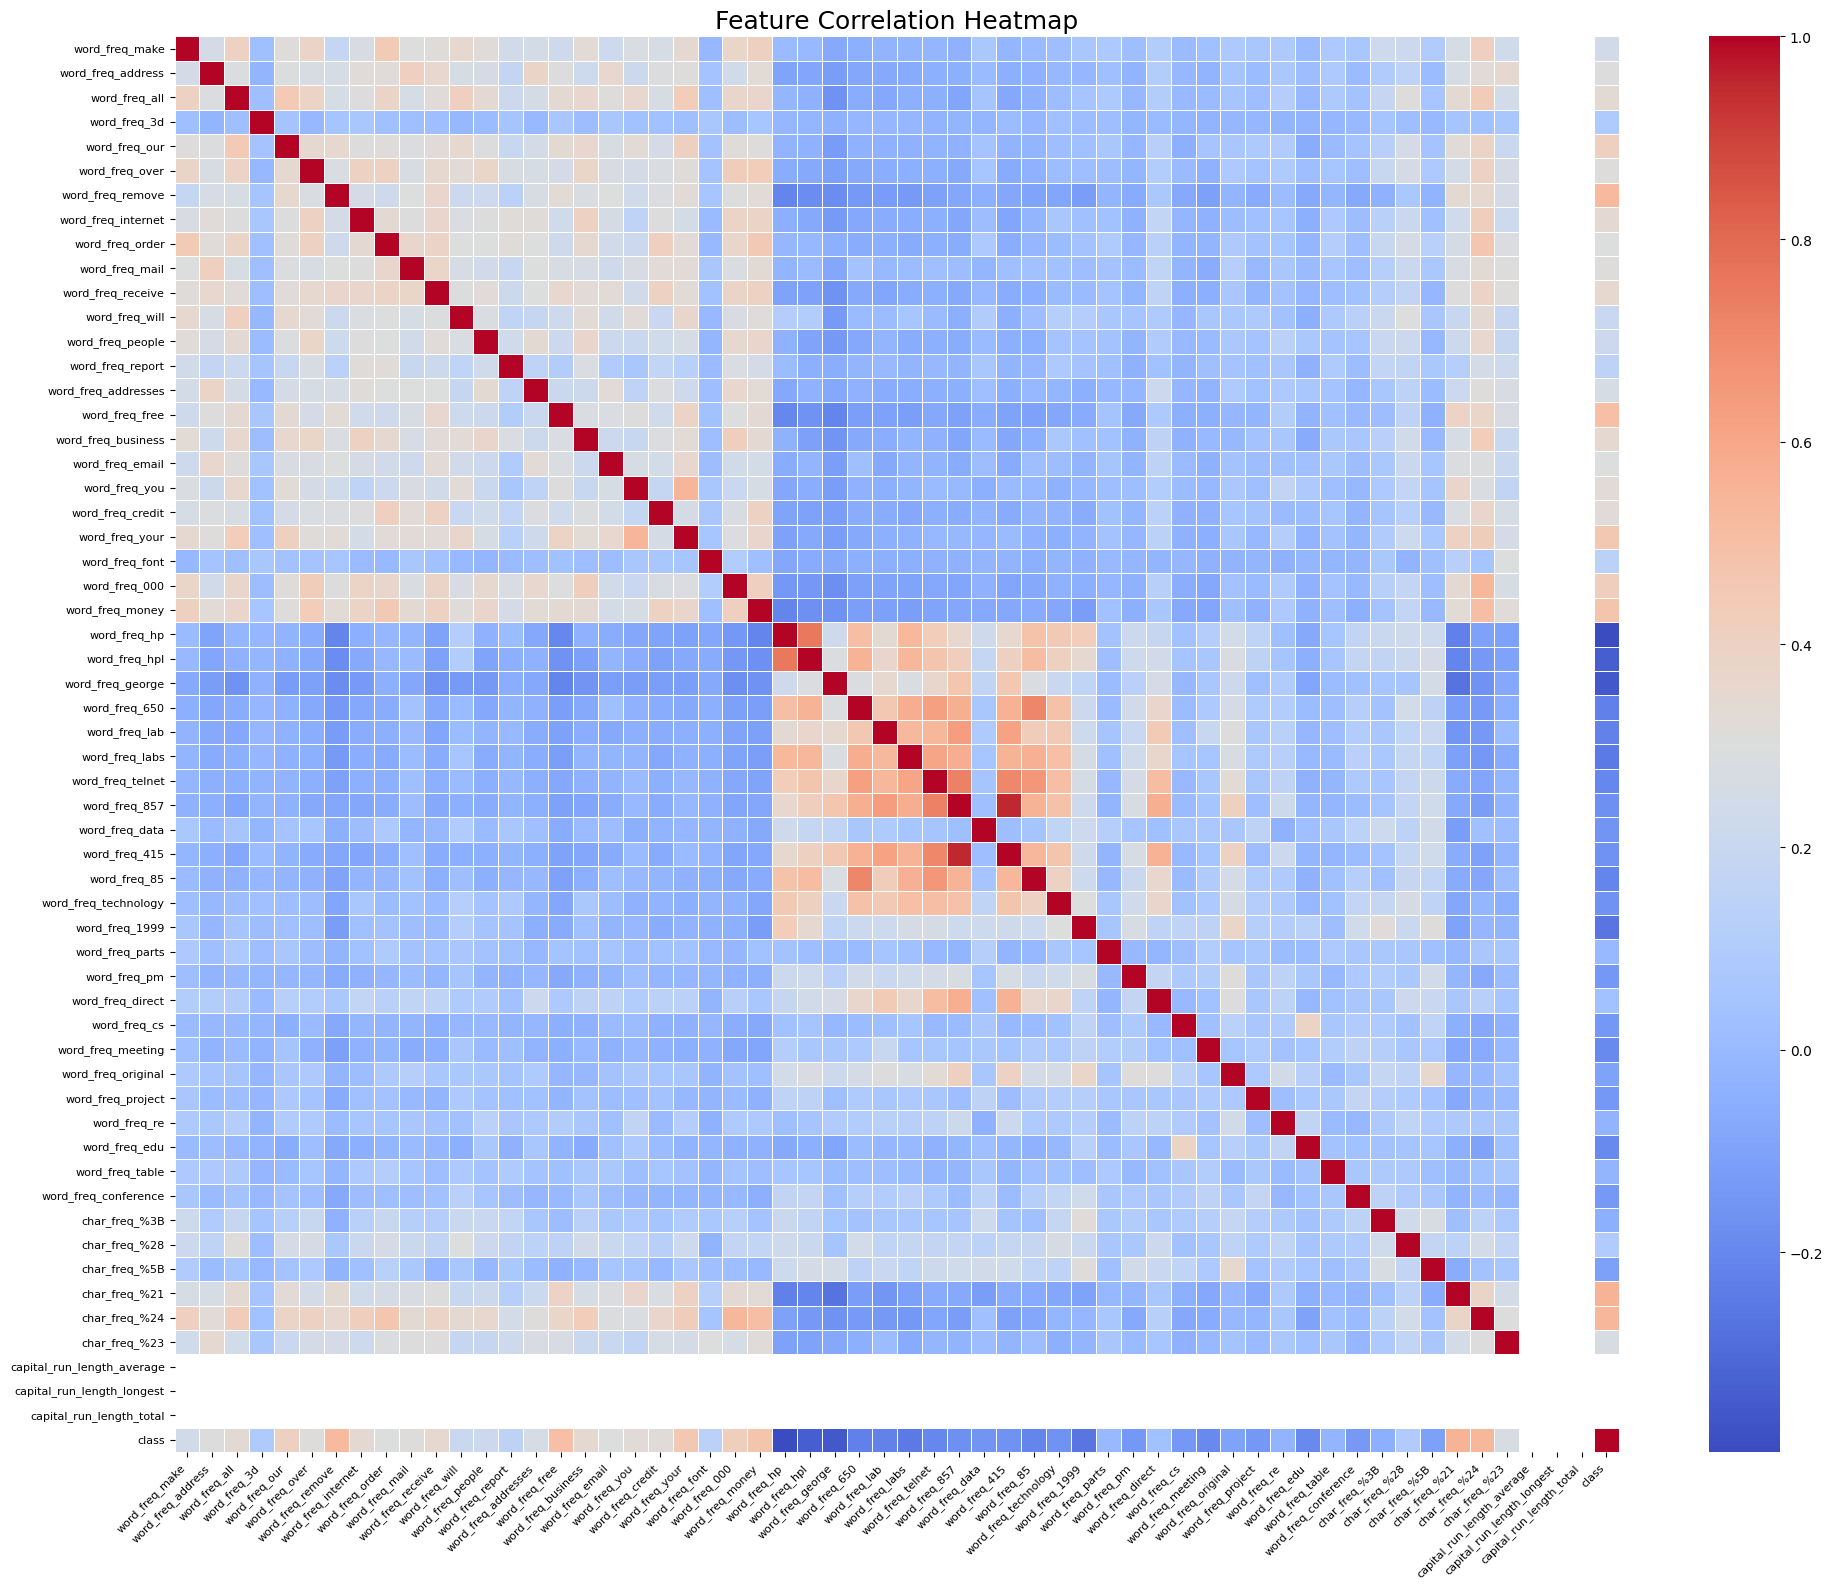

In [ ]:
# --- Histogram Subplots ---
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Optional: Clustered Heatmap (if too many features)
# sns.clustermap(df.corr(), cmap='coolwarm', figsize=(18, 16))
# plt.title("Clustered Correlation Heatmap")
# plt.show()

In [ ]:
# (iv) Splitting dataset

X = df.drop(columns=[target])
y = df[target]

# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')

df.to_csv('updated_spam.csv')

Train: (2760, 57), Validation: (920, 57), Test: (921, 57)


In [ ]:
# (v) Model Training

model = BernoulliNB()

model.fit(X_train, y_train)

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


 Evaluation - Validation Set
Accuracy : 0.8815
Precision: 0.8818
Recall   : 0.8815
F1 Score : 0.8805

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       552
           1       0.89      0.81      0.84       368

    accuracy                           0.88       920
   macro avg       0.88      0.87      0.87       920
weighted avg       0.88      0.88      0.88       920

ROC AUC Score: 0.9581


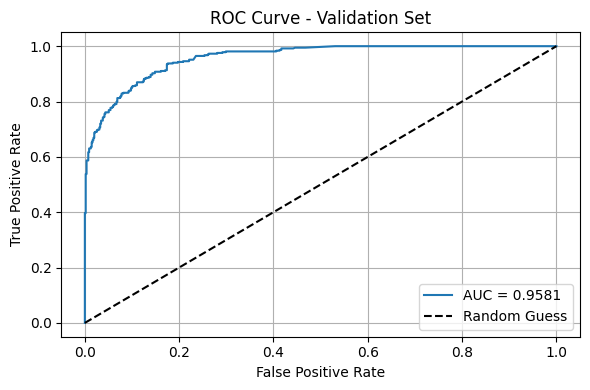


 Evaluation - Test Set
Accuracy : 0.8827
Precision: 0.8836
Recall   : 0.8827
F1 Score : 0.8818

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       537
           1       0.90      0.81      0.85       384

    accuracy                           0.88       921
   macro avg       0.89      0.87      0.88       921
weighted avg       0.88      0.88      0.88       921

ROC AUC Score: 0.9548


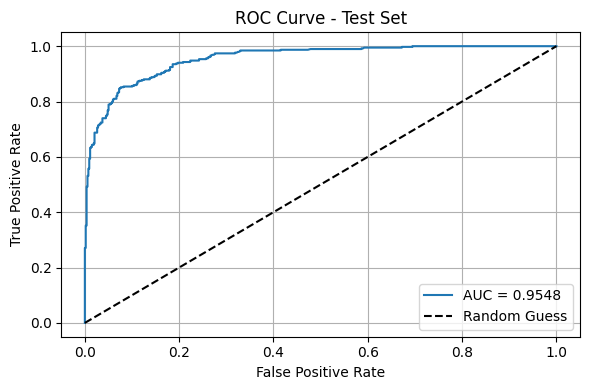

In [ ]:
# (vi) Evaluation

# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)

# For validation set
evaluate_model(y_val, y_val_pred, is_classification, X_val, model, "Validation Set")

# For test set
evaluate_model(y_test, y_test_pred, is_classification, X_test, model, "Test Set")

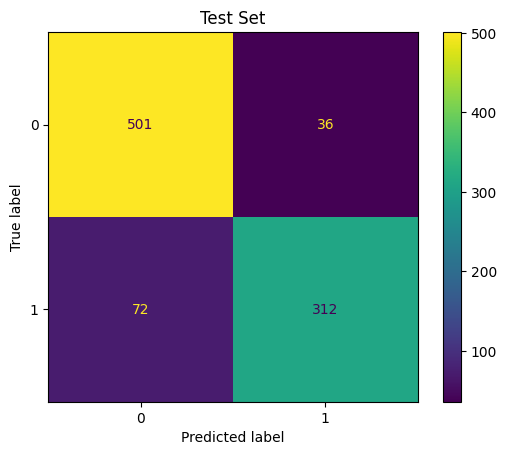

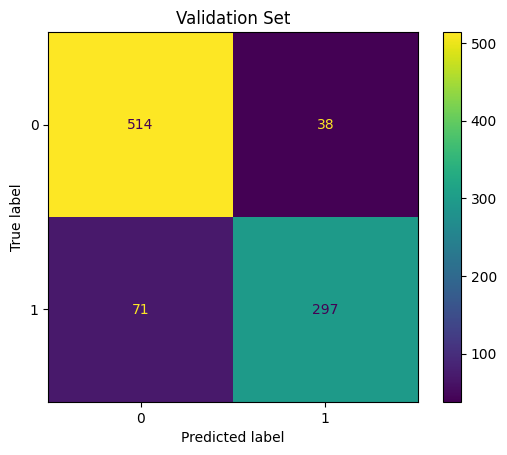

In [ ]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

if not is_classification:
  plot_actual_vs_predicted(y_val, y_val_pred, "Validation Set")
  plot_residuals(y_val, y_val_pred, "Validation Set")
  plot_residual_distribution(y_val, y_val_pred, "Validation Set")

  plot_actual_vs_predicted(y_test, y_test_pred, "Test Set")
  plot_residuals(y_test, y_test_pred, "Test Set")
  plot_residual_distribution(y_test, y_test_pred, "Test Set")
else:
  plot_confusion_matrix(y_test, y_test_pred, "Test Set")
  plot_confusion_matrix(y_val, y_val_pred, "Validation Set")

In [ ]:
# (vii) K-Fold Cross Validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
if is_classification:
    score = 'accuracy'
else:
    score = 'r2'
cv_results = cross_val_score(model, X, y, cv=kfold, scoring=score)

print("Cross Validation Scores:", cv_results)
print("Average CV Score:", np.mean(cv_results))

Cross Validation Scores: [0.8805646  0.89021739 0.88369565 0.88695652 0.89021739]
Average CV Score: 0.8863303120426756
